In [12]:
import yfinance as yf
import pandas as pd

# 코스피 지수 데이터 다운로드
kospi = yf.download('^KS11', start='2024-01-01', end='2024-12-03')

# 종가만 사용
kospi = kospi[['Close']].copy()
kospi.rename(columns={'Close': 'KOSPI'}, inplace=True)
kospi.dropna(inplace=True)
print(kospi.head())

[*********************100%%**********************]  1 of 1 completed

                  KOSPI
Date                   
2024-01-02  2669.810059
2024-01-03  2607.310059
2024-01-04  2587.020020
2024-01-05  2578.080078
2024-01-08  2567.820068


## 1. 이동평균선 전략 백테스팅

In [13]:
# 이동평균선 계산
kospi['Short_MA'] = kospi['KOSPI'].rolling(window=5).mean()  # 단기 이동평균선
kospi['Long_MA'] = kospi['KOSPI'].rolling(window=20).mean()  # 장기 이동평균선

# 매수/매도 신호 생성
kospi['Signal'] = 0
kospi.loc[kospi['Short_MA'] > kospi['Long_MA'], 'Signal'] = 1  # 매수 신호
kospi.loc[kospi['Short_MA'] <= kospi['Long_MA'], 'Signal'] = -1  # 매도 신호

In [18]:
# 초기 투자금
initial_capital = 1000000
#trading_cost = 0.001  # 0.1% 거래 비용

# 포지션 생성
kospi['Position'] = kospi['Signal'].shift()  # 매수/매도 포지션
kospi['Daily_Return'] = kospi['KOSPI'].pct_change()  # 일별 수익률

# 전략 수익 계산
kospi['Strategy_Return'] = kospi['Position'] * kospi['Daily_Return']
#kospi['Strategy_Return'] = kospi['Strategy_Return'] - trading_cost
kospi['Cumulative_Strategy'] = (1 + kospi['Strategy_Return']).cumprod() * initial_capital
kospi['Cumulative_Market'] = (1 + kospi['Daily_Return']).cumprod() * initial_capital

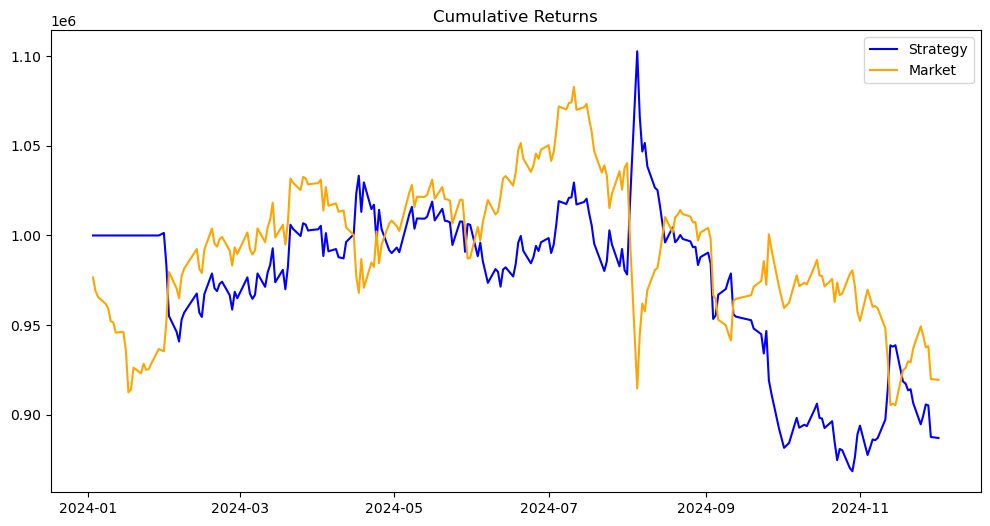

Total Strategy Return: -11.31%
Total Market Return: -8.07%


In [19]:
import matplotlib.pyplot as plt

# 누적 수익률 비교
plt.figure(figsize=(12, 6))
plt.plot(kospi['Cumulative_Strategy'], label='Strategy', color='blue')
plt.plot(kospi['Cumulative_Market'], label='Market', color='orange')
plt.title('Cumulative Returns')
plt.legend()
plt.show()

# 성과 요약
total_strategy_return = kospi['Cumulative_Strategy'].iloc[-1] / initial_capital - 1
total_market_return = kospi['Cumulative_Market'].iloc[-1] / initial_capital - 1
print(f"Total Strategy Return: {total_strategy_return:.2%}")
print(f"Total Market Return: {total_market_return:.2%}")

### 2. 볼린저밴드 백테스팅

In [19]:
import yfinance as yf
import pandas as pd

# 코스피 지수 데이터 다운로드
kospi = yf.download('^KS11', start='2024-01-01', end='2024-12-03')

# 종가만 사용
kospi = kospi[['Close']].copy()
kospi.rename(columns={'Close': 'KOSPI'}, inplace=True)
kospi.dropna(inplace=True)
print(kospi.head())


[*********************100%%**********************]  1 of 1 completed

                  KOSPI
Date                   
2024-01-02  2669.810059
2024-01-03  2607.310059
2024-01-04  2587.020020
2024-01-05  2578.080078
2024-01-08  2567.820068


In [20]:
# 이동평균선과 표준편차 계산
window = 20  # 20일 기준
kospi['MA'] = kospi['KOSPI'].rolling(window=window).mean()  # 중심선
kospi['STD'] = kospi['KOSPI'].rolling(window=window).std()  # 표준편차

# 볼린저 밴드 계산
kospi['Upper_Band'] = kospi['MA'] + (2 * kospi['STD'])  # 상단 밴드
kospi['Lower_Band'] = kospi['MA'] - (2 * kospi['STD'])  # 하단 밴드

# 볼린저 밴드 계산 완료
kospi.dropna(inplace=True)

In [22]:
# 매수 신호: 하단 밴드를 밑돌고, 다음 날 다시 상향 돌파 시
kospi['Buy_Signal'] = (kospi['KOSPI'] < kospi['Lower_Band']) & (kospi['KOSPI'].shift(1) >= kospi['Lower_Band'])

# 매도 신호: 상단 밴드를 돌파하고, 다음 날 다시 하향 돌파 시
kospi['Sell_Signal'] = (kospi['KOSPI'] > kospi['Upper_Band']) & (kospi['KOSPI'].shift(1) <= kospi['Upper_Band'])

In [23]:
# 초기 자본금 설정
initial_capital = 1000000

# 포지션 생성: 매수는 1, 매도는 0
kospi['Position'] = 0
kospi.loc[kospi['Buy_Signal'], 'Position'] = 1  # 매수
kospi.loc[kospi['Sell_Signal'], 'Position'] = 0  # 매도

# 포지션을 유지 (누적 상태로 표현)
kospi['Position'] = kospi['Position'].ffill().fillna(0)

# 일별 수익률 계산
kospi['Daily_Return'] = kospi['KOSPI'].pct_change()
kospi['Strategy_Return'] = kospi['Position'] * kospi['Daily_Return']

# 누적 수익률 계산
kospi['Cumulative_Strategy'] = (1 + kospi['Strategy_Return']).cumprod() * initial_capital
kospi['Cumulative_Market'] = (1 + kospi['Daily_Return']).cumprod() * initial_capital

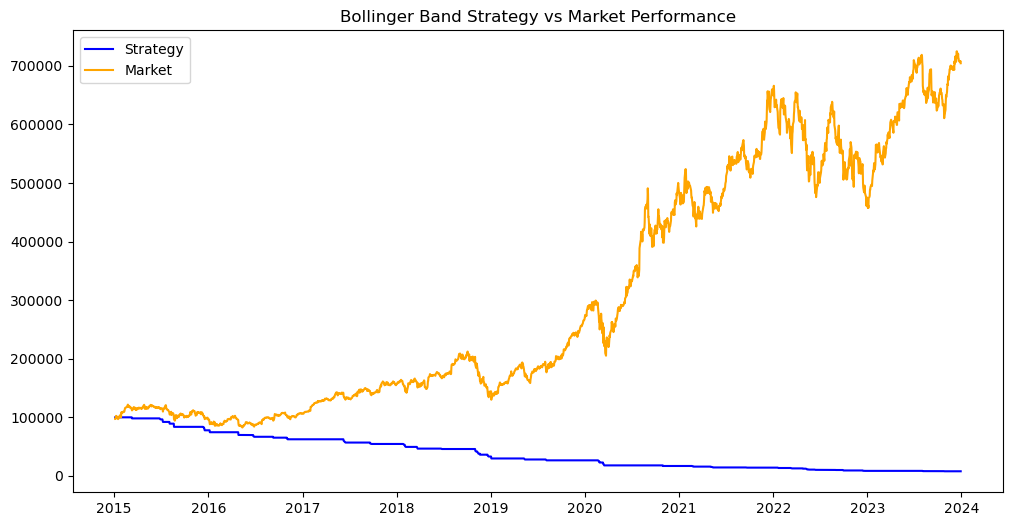

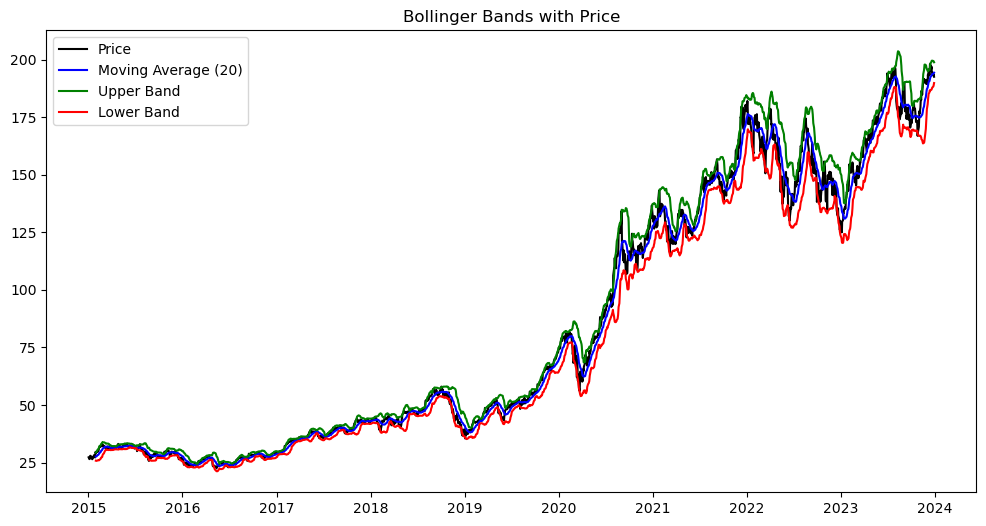

Total Strategy Return: -99.21%
Total Market Return: -29.56%


In [15]:
import matplotlib.pyplot as plt

# 누적 수익률 시각화
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Strategy'], label='Strategy', color='blue')
plt.plot(data['Cumulative_Market'], label='Market', color='orange')
plt.title('Bollinger Band Strategy vs Market Performance')
plt.legend()
plt.show()

# 볼린저 밴드와 가격 시각화
plt.figure(figsize=(12, 6))
plt.plot(data['KOSPI'], label='KOSPI', color='black')
plt.plot(data['MA'], label='Moving Average (20)', color='blue')
plt.plot(data['Upper_Band'], label='Upper Band', color='green')
plt.plot(data['Lower_Band'], label='Lower Band', color='red')
plt.title('Bollinger Bands with Price')
plt.legend()
plt.show()

# 성과 요약
total_strategy_return = data['Cumulative_Strategy'].iloc[-1] / initial_capital - 1
total_market_return = data['Cumulative_Market'].iloc[-1] / initial_capital - 1
print(f"Total Strategy Return: {total_strategy_return:.2%}")
print(f"Total Market Return: {total_market_return:.2%}")

[*********************100%%**********************]  1 of 1 completed


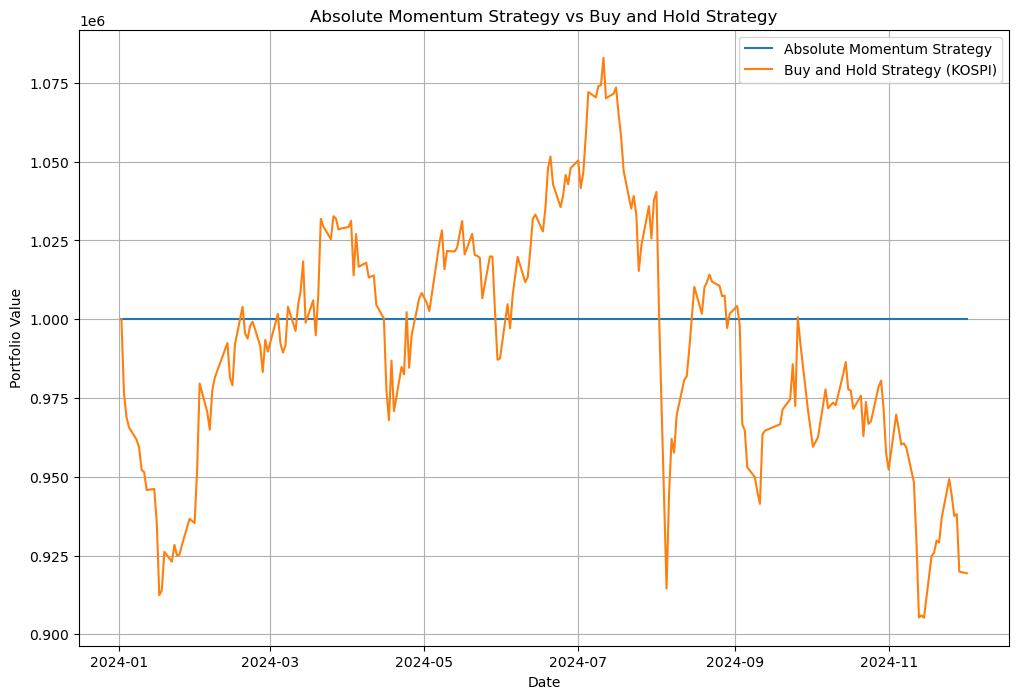

In [30]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 코스피 지수 데이터 다운로드
kospi = yf.download('^KS11', start='2024-01-01', end='2024-12-03')['Adj Close']

# 절대 모멘텀 계산 (최근 12개월 수익률)
momentum_period = 252  # 12개월 (거래일 기준)
momentum = kospi.pct_change(periods=momentum_period)

# 투자 신호 생성
signal = (momentum > 0).astype(int)

# 투자 전략 백테스트
initial_investment = 1000000  # 초기 투자금
portfolio = pd.DataFrame(index=kospi.index)
portfolio['KOSPI'] = kospi
portfolio['Signal'] = signal.shift(1).fillna(0)
portfolio['Holdings'] = initial_investment * (1 + portfolio['Signal'] * kospi.pct_change().fillna(0)).cumprod()

# 결과 시각화
plt.figure(figsize=(12, 8))
plt.plot(portfolio['Holdings'], label='Absolute Momentum Strategy')
plt.plot(initial_investment * (1 + kospi.pct_change().fillna(0)).cumprod(), label='Buy and Hold Strategy (KOSPI)')
plt.legend()
plt.title('Absolute Momentum Strategy vs Buy and Hold Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()